In [1]:
%pip install --upgrade pip

# Uninstall conflicting packages
%pip uninstall -y langchain-core langchain-openai langchain-experimental langchain-community langchain chromadb beautifulsoup4 python-dotenv PyPDF2 rank_bm25 ragas tqdm matplotlib 

# Install compatible versions of langchain-core and langchain-openai
%pip install langchain-core==0.3.6
%pip install langchain-openai==0.2.1
%pip install langchain-experimental==0.3.2
%pip install langchain-community==0.3.1
%pip install langchain==0.3.1

# Install remaining packages
%pip install chromadb==0.5.11
%pip install python-dotenv==1.0.1
%pip uninstall uvloop -y
%pip install PyPDF2==3.0.1 -q --user
%pip install rank_bm25==0.2.2

# new
%pip install ragas==0.1.20
%pip install tqdm==4.66.5 -q --user
%pip install matplotlib==3.9.2

Note: you may need to restart the kernel to use updated packages.
Found existing installation: langchain-core 0.3.28
Uninstalling langchain-core-0.3.28:
  Successfully uninstalled langchain-core-0.3.28
Found existing installation: langchain-openai 0.2.1
Uninstalling langchain-openai-0.2.1:
  Successfully uninstalled langchain-openai-0.2.1
Found existing installation: langchain-experimental 0.3.2
Uninstalling langchain-experimental-0.3.2:
  Successfully uninstalled langchain-experimental-0.3.2
Found existing installation: langchain-community 0.3.1
Uninstalling langchain-community-0.3.1:
  Successfully uninstalled langchain-community-0.3.1
Found existing installation: langchain 0.3.1
Uninstalling langchain-0.3.1:
  Successfully uninstalled langchain-0.3.1
Found existing installation: chromadb 0.5.11
Uninstalling chromadb-0.5.11:
  Successfully uninstalled chromadb-0.5.11
Found existing installation: python-dotenv 1.0.1
Uninstalling python-dotenv-1.0.1:
  Successfully uninstalled python-d

In [1]:
import os
os.environ['USER_AGENT'] = 'RAGUserAgent'
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnableParallel
from dotenv import load_dotenv, find_dotenv
from langchain_core.prompts import PromptTemplate
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

## new
import tqdm as notebook_tqdm
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from ragas import evaluate
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness,
    answer_similarity
)

Matplotlib is building the font cache; this may take a moment.


In [2]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
embedding_function = OpenAIEmbeddings()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
pdf_path = "google-2023-environmental-report.pdf"
collection_name = "google_environmental_report"
str_output_parser = StrOutputParser()
user_query = "What are Google's environmental initiatives?"

In [3]:
embedding_ada = "text-embedding-ada-002"
model_gpt35="gpt-3.5-turbo"
model_gpt4="gpt-4o-mini"

embedding_function = OpenAIEmbeddings(model=embedding_ada, openai_api_key=openai.api_key)
llm = ChatOpenAI(model=model_gpt35, openai_api_key=openai.api_key, temperature=0.0)
generator_llm = ChatOpenAI(model=model_gpt35, openai_api_key=openai.api_key, temperature=0.0)
critic_llm = ChatOpenAI(model=model_gpt4, openai_api_key=openai.api_key, temperature=0.0)

In [4]:
pdf_reader = PdfReader(pdf_path)
text = ""
for page in pdf_reader.pages:
    text += page.extract_text()

In [5]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=200
)
splits = character_splitter.split_text(text)

In [6]:
dense_documents = [Document(page_content=text, metadata={"id": str(i), "source": "dense"}) for i, text in enumerate(splits)]
sparse_documents = [Document(page_content=text, metadata={"id": str(i), "source": "sparse"}) for i, text in enumerate(splits)]

In [7]:
chroma_client = chromadb.Client()
vectorstore = Chroma.from_documents(
    documents=dense_documents,
    embedding=embedding_function,
    collection_name=collection_name,
    client=chroma_client
)

In [8]:
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
sparse_retriever = BM25Retriever.from_documents(sparse_documents, k=10)
ensemble_retriever = EnsembleRetriever(retrievers=[dense_retriever, sparse_retriever], weights=[0.5, 0.5], c=0)


In [9]:
prompt = hub.pull("jclemens24/rag-prompt")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
relevance_prompt_template = PromptTemplate.from_template(
    """
    Given the following question and retrieved context, determine if the context is relevant to the question.
    Provide a score from 1 to 5, where 1 is not at all relevant and 5 is highly relevant.
    Return ONLY the numeric score, without any additional text or explanation.

    Question: {question}
    Retrieved Context: {retrieved_context}

    Relevance Score:"""
)


In [11]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [12]:
def extract_score(llm_output):
    try:
        score = float(llm_output.strip())
        return score
    except ValueError:
        return 0

# Chain it all together with LangChain
def conditional_answer(x):
    relevance_score = extract_score(x['relevance_score'])
    if relevance_score < 4:
        return "I don't know."
    else:
        return x['answer']

In [13]:
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | RunnableParallel(
        {"relevance_score": (
            RunnablePassthrough()
            | (lambda x: relevance_prompt_template.format(question=x['question'], retrieved_context=x['context']))
            | llm
            | str_output_parser
        ), "answer": (
            RunnablePassthrough()
            | prompt
            | llm
            | str_output_parser
        )}
    )
    | RunnablePassthrough().assign(final_answer=conditional_answer)
)


In [14]:
rag_chain_similarity = RunnableParallel(
    {"context": dense_retriever,
     "question": RunnablePassthrough()
}).assign(answer=rag_chain_from_docs)


In [15]:
rag_chain_hybrid = RunnableParallel(
    {"context": ensemble_retriever,
     "question": RunnablePassthrough()
}).assign(answer=rag_chain_from_docs)


In [16]:
result = rag_chain_similarity.invoke(user_query)
retrieved_docs = result['context']

print(f"Original Question to Similarity Search: {user_query}\n")
print(f"Relevance Score: {result['answer']['relevance_score']}\n")
print(f"Final Answer:\n{result['answer']['final_answer']}\n\n")
print("Retrieved Documents:")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"Document {i}: Document ID: {doc.metadata['id']} source: {doc.metadata['source']}")
    print(f"Content:\n{doc.page_content}\n")

Original Question to Similarity Search: What are Google's environmental initiatives?

Relevance Score: 5

Final Answer:
Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, water stewardship, and promoting a circular economy. They have implemented sustainability features in products like Google Maps, Google Nest thermostats, and Google Flights to help individuals make more sustainable choices. Google is also involved in public policy advocacy, supporting initiatives like the iMasons Climate Accord, ReFED, and The Nature Conservancy. Additionally, Google is a member of organizations like the World Business Council for Sustainable Development and the World Resources Institute to collaborate on sustainability projects.


Retrieved Documents:
Document 1: Document ID: 451 source: dense
Content:
Empowering individuals:  
A parking lot full of electric vehicle

In [17]:
result = rag_chain_hybrid.invoke(user_query)
retrieved_docs = result['context']

print(f"Original Question to Dense Search: {user_query}\n")
print(f"Relevance Score: {result['answer']['relevance_score']}\n")
print(f"Final Answer:\n{result['answer']['final_answer']}\n\n")
print("Retrieved Documents:")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"Document {i}: Document ID: {doc.metadata['id']} source: {doc.metadata['source']}")
    print(f"Content:\n{doc.page_content}\n")

Original Question to Dense Search: What are Google's environmental initiatives?

Relevance Score: 5

Final Answer:
Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, focusing on water stewardship, engaging in a circular economy, and supporting sustainable consumption of public goods. They also engage with suppliers to reduce energy consumption and greenhouse gas emissions, report environmental data, and assess environmental criteria. Google is involved in various sustainability initiatives and coalitions, such as the iMasons Climate Accord, ReFED, and The Nature Conservancy. They also work with organizations like the World Business Council for Sustainable Development and the World Resources Institute. Additionally, Google is focused on renewable energy, data center efficiency, and using technology to drive sustainability progress.


Retrieved Document

In [18]:
generator = TestsetGenerator.from_langchain(generator_llm, critic_llm, embedding_function)

In [19]:
documents = [Document(page_content=chunk) for chunk in splits]

In [20]:
testset = generator.generate_with_langchain_docs(
    documents,
    test_size = 10,
    distributions = {
        simple: 0.5,
        reasoning: 0.25,
        multi_context: 0.25
    }
)

embedding nodes:   0%|          | 0/906 [00:00<?, ?it/s]

Filename and doc_id are the same for all nodes.


Generating:   0%|          | 0/10 [00:00<?, ?it/s]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
testset_df = testset.to_pandas()
testset_df.to_csv(os.path.join('testset_data.csv'), index=False)
print("testset DataFrame saved successfully in the local directory")

testset DataFrame saved successfully in the local directory


In [22]:
saved_testset_df = pd.read_csv(os.path.join('testset_data.csv'))
print("testset DataFrame loaded successfully from loacl directory")
saved_testset_df.head(5)

testset DataFrame loaded successfully from loacl directory


,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How does the climate-conscious data center coo...,"['In 2022, we described our climate-conscious ...",The climate-conscious data center cooling stra...,simple,[{}],True
1,What is the significance of achieving certific...,"['In 2022, we certified 90% of our established...",Achieving certification to the UL 2799 Zero Wa...,simple,[{}],True
2,What is the significance of the green badge in...,"['When individuals search in Google Flights, t...",The green badge in Google Flights indicates fl...,simple,[{}],True
3,How did Google.org support nonprofit-led proje...,['Global Covenant of Mayors for Climate & Ener...,Google.org provided a $10 million grant to ICL...,simple,[{}],True
4,What is the title of Google's climate change p...,['We’ve consistently supported strong climate ...,Realizing a carbon-free future: Google’s Third...,simple,[{}],True


In [23]:
saved_testing_data = saved_testset_df.astype(str).to_dict(orient='list')
saved_testing_dataset = Dataset.from_dict(saved_testing_data)

saved_testing_dataset_sm = saved_testing_dataset.remove_columns(["evolution_type", "episode_done"])

In [24]:
saved_testing_dataset_sm

Dataset({
    features: ['question', 'contexts', 'ground_truth', 'metadata'],
    num_rows: 9
})

In [27]:
def generate_answer(question, ground_truth, rag_chain):
    result = rag_chain.invoke(question)
    return {
        "question": question,
        "answer": result['answer']['final_answer'],
        "contexts": [doc.page_content for doc in result["context"]],
        "ground_truth": ground_truth
    }
    
    

In [28]:
testing_dataset_similarity = saved_testing_dataset_sm.map(lambda x: generate_answer(x["question"], x["ground_truth"], rag_chain_similarity), remove_columns=saved_testing_dataset_sm.column_names)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [29]:
testing_dataset_hybrid = saved_testing_dataset_sm.map(lambda x: generate_answer(x['question'], x['ground_truth'], rag_chain_hybrid), remove_columns=saved_testing_dataset_sm.column_names)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [32]:
score_similarity = evaluate(
    testing_dataset_similarity,
    metrics = [
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        answer_correctness,
        answer_similarity]
)
similarity_df = score_similarity.to_pandas()
similarity_df

Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,answer_similarity
0,How does the climate-conscious data center coo...,[85We’re working to achieve 24/7 CFE through t...,The climate-conscious data center cooling stra...,The climate-conscious data center cooling stra...,0.666667,0.947529,1.000000,1.000000,0.704031,0.969970
1,What is the significance of achieving certific...,"[In 2022, we certified 90% of our established ...",Achieving certification to the UL 2799 Zero Wa...,Achieving certification to the UL 2799 Zero Wa...,0.714286,0.989568,1.000000,0.666667,0.687817,0.986564
2,What is the significance of the green badge in...,"[When individuals search in Google Flights, th...",The significance of the green badge in Google ...,The green badge in Google Flights indicates fl...,1.000000,0.944709,0.835000,1.000000,0.912444,0.983108
3,How did Google.org support nonprofit-led proje...,"[In Europe, our CEO Sundar Pichai shared virtu...",Google.org supported nonprofit-led projects in...,Google.org provided a $10 million grant to ICL...,0.888889,0.908912,0.111111,1.000000,0.506146,0.899584
4,What is the title of Google's climate change p...,[We’ve consistently supported strong climate p...,The title of Google's climate change public po...,Realizing a carbon-free future: Google’s Third...,1.000000,1.000000,1.000000,1.000000,0.986450,0.945798
5,How does Google Flights use TIM for carbon emi...,"[When individuals search in Google Flights, th...",Google Flights uses the Travel Impact Model (T...,Google Flights uses the Travel Impact Model (T...,1.000000,0.894364,0.916667,1.000000,0.599869,0.987709
6,How does Google work with RSMetrics and Infosy...,[Many of our commercial customers are eager to...,Google works with RSMetrics and Infosys to hel...,Google partners with RSMetrics and Infosys to ...,1.000000,0.912609,1.000000,1.000000,0.859395,0.966990
7,What environmental data does an auditor review...,[Assurance\nWe obtain limited third-party assu...,An auditor reviews environmental data such as ...,An independent auditor reviews select environm...,1.000000,0.932805,0.906041,1.000000,0.631375,0.969973
8,How does Google aim to replenish more freshwat...,[In addition to focusing on responsible water ...,Google aims to replenish 20% more freshwater t...,Google aims to replenish 20% more freshwater t...,0.714286,0.924531,0.988889,1.000000,0.648719,0.994876


In [34]:
score_hybrid = evaluate(
    testing_dataset_hybrid,
    metrics = [
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        answer_correctness,
        answer_similarity
    ]
)
hybrid_df = score_hybrid.to_pandas()
hybrid_df

Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,answer_similarity
0,How does the climate-conscious data center coo...,"[In 2022, we described our climate-conscious d...",The climate-conscious data center cooling stra...,The climate-conscious data center cooling stra...,0.400000,0.972701,0.924442,1.0,0.823432,0.986037
1,What is the significance of achieving certific...,"[In 2022, we certified 90% of our established ...",Achieving certification to the UL 2799 Zero Wa...,Achieving certification to the UL 2799 Zero Wa...,0.714286,0.989568,0.990909,1.0,0.746641,0.986564
2,What is the significance of the green badge in...,"[When individuals search in Google Flights, th...",The significance of the green badge in Google ...,The green badge in Google Flights indicates fl...,0.875000,0.979404,0.642674,1.0,0.713856,0.980423
3,How did Google.org support nonprofit-led proje...,"[In Europe, our CEO Sundar Pichai shared virtu...",Google.org supported nonprofit-led projects in...,Google.org provided a $10 million grant to ICL...,1.000000,0.957298,0.444444,1.0,0.705492,0.946944
4,What is the title of Google's climate change p...,[We’ve consistently supported strong climate p...,The title of Google's climate change public po...,Realizing a carbon-free future: Google’s Third...,1.000000,1.000000,1.000000,1.0,0.986450,0.945798
5,How does Google Flights use TIM for carbon emi...,"[When individuals search in Google Flights, th...",Google Flights uses the Travel Impact Model (T...,Google Flights uses the Travel Impact Model (T...,0.500000,0.902902,0.840909,1.0,0.782494,0.987119
6,How does Google work with RSMetrics and Infosy...,[Many of our commercial customers are eager to...,Google works with RSMetrics and Infosys to hel...,Google partners with RSMetrics and Infosys to ...,0.875000,0.912609,0.809524,1.0,0.991933,0.967731
7,What environmental data does an auditor review...,[Assurance\nWe obtain limited third-party assu...,An auditor reviews certain environmental data ...,An independent auditor reviews select environm...,1.000000,0.934427,0.597092,1.0,0.897394,0.980879
8,How does Google aim to replenish more freshwat...,[In addition to focusing on responsible water ...,Google aims to replenish 20% more freshwater t...,Google aims to replenish 20% more freshwater t...,0.777778,0.924531,0.919151,1.0,0.848721,0.994884


In [37]:
key_columns = [
    'faithfulness',
    'answer_relevancy',
    'context_precision',
    'context_recall',
    'answer_correctness',
    'answer_similarity'
]
similarity_means = similarity_df[key_columns].mean()
hybrid_means = hybrid_df[key_columns].mean()
comparison_df = pd.DataFrame({'Similarity Run': similarity_means, 'Hybrid Run': hybrid_means})
comparison_df['Difference'] = comparison_df['Similarity Run'] - comparison_df['Hybrid Run']

similarity_df.to_csv(os.path.join('similarity_run_data.csv'), index=False)
hybrid_df.to_csv(os.path.join('hybrid_run_data.csv'), index=False)
comparison_df.to_csv(os.path.join('comparison_data.csv'), index=True)

print("Dataframes saved successfully in the local directory.")

Dataframes saved successfully in the local directory.


In [40]:
sem_df = pd.read_csv(os.path.join('similarity_run_data.csv'))
rec_df = pd.read_csv(os.path.join('hybrid_run_data.csv'))
comparison_df = pd.read_csv(os.path.join('comparison_data.csv'), index_col=0)
print("Dataframes loaded successfully from the local directory")
print("Performance Comparison")
print("\n**Retrieval**:")
print(comparison_df.loc[['context_precision', 'context_recall']])
print("\n**Generation**:")
print(comparison_df.loc[['faithfulness', 'answer_relevancy']])
print("\n**End to end evaluation**:")
print(comparison_df.loc[['answer_correctness', 'answer_similarity']])

Dataframes loaded successfully from the local directory
Performance Comparison

**Retrieval**:
                   Similarity Run  Hybrid Run  Difference
context_precision        0.861967    0.796572    0.065396
context_recall           0.962963    1.000000   -0.037037

**Generation**:
                  Similarity Run  Hybrid Run  Difference
faithfulness            0.887125    0.793563    0.093563
answer_relevancy        0.939447    0.952604   -0.013157

**End to end evaluation**:
                    Similarity Run  Hybrid Run  Difference
answer_correctness        0.726249    0.832935   -0.106685
answer_similarity         0.967175    0.975153   -0.007979


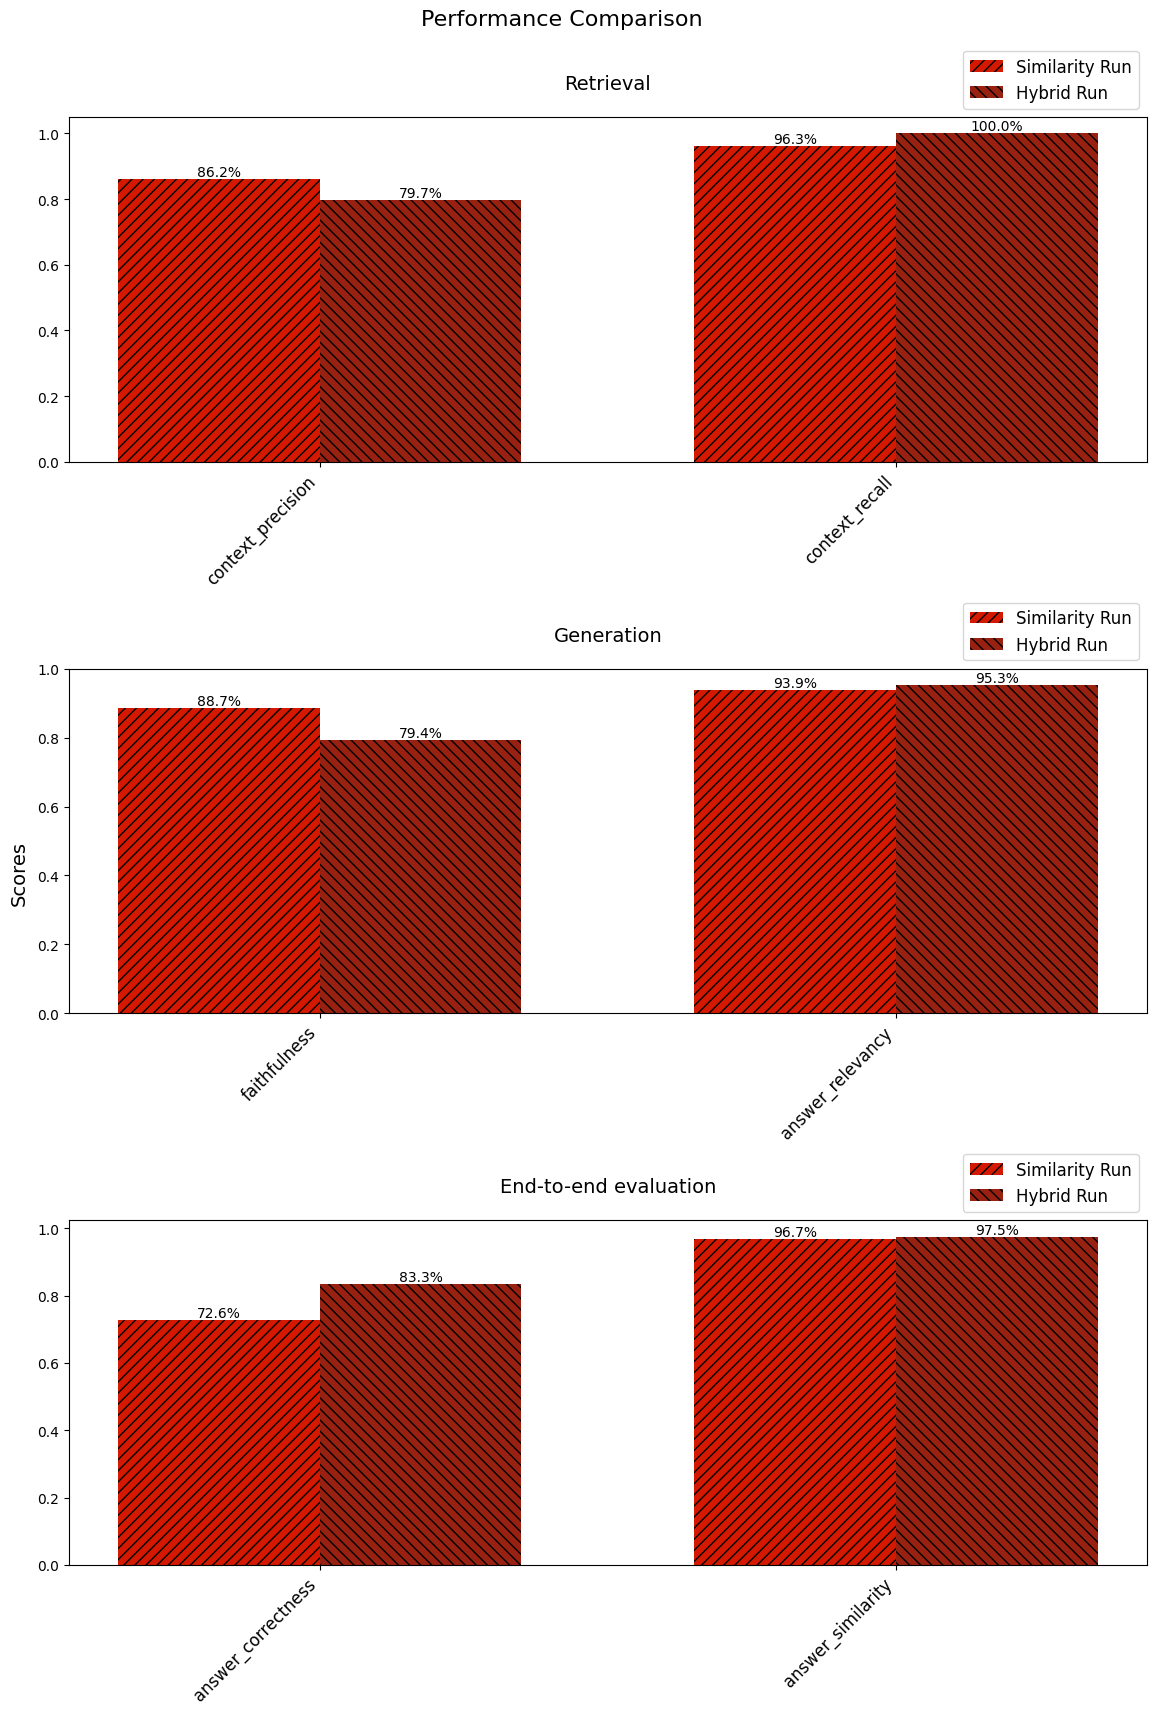

In [42]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)
bar_width = 0.35
categories = ['Retrieval', 'Generation', 'End-to-end evaluation']
metrics = [
    ['context_precision', 'context_recall'],
    ['faithfulness', 'answer_relevancy'],
    ['answer_correctness', 'answer_similarity']
]

# iterate over each category and plot the corresponding metrics
for i, (category, metric_list) in enumerate(zip(categories, metrics)):
    ax = axes[i]
    x = range(len(metric_list))

    # plot bars for Similarity Run (hex color #D51900)
    similarity_bars = ax.bar(x, comparison_df.loc[metric_list, 'Similarity Run'], width=bar_width, label='Similarity Run', color='#D51900', hatch='///')

    # add values to Similarity Run bars
    for bar in similarity_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    # plot bars for Hybrid Run (hex color #992111)
    hybrid_bars = ax.bar([i + bar_width for i in x], comparison_df.loc[metric_list, 'Hybrid Run'], width=bar_width, label='Hybrid Run', color='#992111', hatch='\\\\\\')

    # add values to Hybrid Run bars
    for bar in hybrid_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    ax.set_title(category, fontsize=14, pad=20)
    ax.set_xticks([i + bar_width / 2 for i in x])
    ax.set_xticklabels(metric_list, rotation=45, ha='right', fontsize=12)

    # move the legend to the bottom right corner
    ax.legend(fontsize=12, loc='lower right', bbox_to_anchor=(1, 1))

# Add overall labels and title
fig.text(0.04, 0.5, 'Scores', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Performance Comparison', fontsize=16)

# adjust the spacing between subplots and increase the top margin
plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.6, top=0.92)
plt.show()